In [ ]:
!wget https://raw.githubusercontent.com/heisenberg967/ner_twitter/main/data/train.txt # train data
!wget https://raw.githubusercontent.com/heisenberg967/ner_twitter/main/data/validation.txt # validation data
!wget https://raw.githubusercontent.com/heisenberg967/ner_twitter/main/data/test.txt # test data

In [ ]:
import pandas as pd

def read_data(file_path):
    tokens = []
    tags = []
    dataframe_list = []
    tweet_tokens = []
    tweet_tags = []
    for line in open(file_path, encoding='utf-8'):
        line = line.strip()
        if not line:
            if tweet_tokens:
                k = []
                k.append(tweet_tokens)
                k.append(tweet_tags)
                dataframe_list.append(k)
                tokens.append(tweet_tokens)
                tags.append(tweet_tags)
            tweet_tokens = []
            tweet_tags = []
        else:
            token, tag = line.split()
            if token.startswith('@'):
                token = '<USR>'
            elif token.lower().startswith('https://') or token.lower().startswith('http://'):
                token = '<URL>'
            
            tweet_tokens.append(token)
            tweet_tags.append(tag)
            
    df = pd.DataFrame(dataframe_list,columns=["tokens","tags"])
    
    return tokens, tags , df




In [ ]:
train_tokens, train_tags, train_df = read_data('data/train.txt')
validation_tokens, validation_tags,valid_df = read_data('data/validation.txt')
test_tokens, test_tags, test_df = read_data('data/test.txt')

In [ ]:
from collections import defaultdict
def build_dict(tokens_or_tags, special_tokens):
    """
        tokens_or_tags: a list of lists of tokens or tags
        special_tokens: some special tokens
    """
    # Create a dictionary with default value 0
    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    
    # Create mappings from tokens to indices and vice versa
    # Add special tokens to dictionaries
    # The first special token must have index 0
    
    voc = set([x for ele in tokens_or_tags for x in ele])
    voc_size = len(voc)+len(special_tokens)
    idx2tok = ['']*voc_size

    for i,token in enumerate(special_tokens):
        #print(i)
        tok2idx[token] = i
        idx2tok[i] = token
    
    for i, token in enumerate(voc, len(special_tokens)):
        tok2idx[token] = i-1
        idx2tok[i] = token
        
    
    return tok2idx, idx2tok



In [ ]:
special_tokens = ['<UNK>', '<PAD>']
special_tags = ['O']

# Create dictionaries 
token2idx, idx2token = build_dict(train_tokens + validation_tokens, special_tokens)
tag2idx, idx2tag = build_dict(train_tags, special_tags)

def add_token_or_tag_idx(token2idx,tag2idx,df):
  token_idx = []
  tag_idx = []
  for i in range(len(df)):
    tkn_idx = []
    tg_idx = []
    for token in df["tokens"].iloc[i]:
      tkn_idx.append(token2idx[token])
    token_idx.append(tkn_idx)
  
    for tag in df["tags"].iloc[i]:
      tg_idx.append(tag2idx[tag])
    tag_idx.append(tg_idx)
  
  df["token_idx"] = token_idx
  df["tag_idx"] = tag_idx

In [ ]:
add_token_or_tag_idx(token2idx,tag2idx,train_df)
add_token_or_tag_idx(token2idx,tag2idx,valid_df)
add_token_or_tag_idx(token2idx,tag2idx,test_df)


In [ ]:
train_df["tag_idx"].iloc[10]
#test_df.head()

In [ ]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [ ]:
tag2idx

In [ ]:
import numpy as np
def get_pad_train_test_val(data_group,df,token2idx,tag2idx):

    #get max token and tag length
    n_token = len(token2idx)

    n_tag = len(tag2idx)
    print(n_tag)

    #Pad tokens (X var)    
    max_tokens = df['token_idx'].tolist()
    maxlen = max([len(s) for s in max_tokens])
    print(maxlen)
    tokens = data_group['token_idx'].tolist()
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token-1)
    print(pad_tokens)
    #Pad Tags (y var) and convert it into one hot encoding
    tags = data_group['tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    print(pad_tags.shape)
    n_tags = len(tag2idx)
    #print(pad_tags[5794],len(pad_tokens))
    tags_lst = []
    for i in range(len(pad_tags)):
      try:
        tags_lst.append(to_categorical(pad_tags[i],num_classes=n_tags))
        #print(len(pad_tags[i]))
      except Exception as e:
        print(e,"error",i,pad_tags[i],len(pad_tags[i]),type(pad_tags[i]))
  
    print(len(pad_tokens),len(tags_lst))
    return pad_tokens, np.array(tags_lst)

In [ ]:
pad_train_token, pad_train_tag = get_pad_train_test_val(train_df,train_df,token2idx,tag2idx)
pad_valid_token, pad_valid_tag = get_pad_train_test_val(valid_df,train_df,token2idx,tag2idx)
pad_test_token, pad_test_tag = get_pad_train_test_val(test_df,train_df,token2idx,tag2idx)

In [ ]:
pad_train_tag.shape

(5795, 41, 21)

In [ ]:
import numpy as np
import tensorflow
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model

In [ ]:
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [ ]:
input_dim = len(token2idx)
output_dim = 64
input_length = max([len(s) for s in train_df['token_idx'].tolist()])
n_tags = len(tag2idx)
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  21966 
output_dim:  64 
input_length:  41 
n_tags:  21


In [ ]:
def get_bilstm_lstm_model():
    model = Sequential()

    # Add Embedding layer
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))

    # Add bidirectional LSTM
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))

    # Add LSTM
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))

    # Add timeDistributed Layer
    model.add(TimeDistributed(Dense(n_tags, activation="relu")))

    #Optimiser 
    # adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [ ]:
def train_model(X, y, model):
    loss = list()
    for i in range(25):
        # fit model for one epoch on this sequence
        hist = model.fit(X, y, batch_size=100, verbose=1, epochs=1, validation_split=0.2)
        loss.append(hist.history['loss'][0])
    return loss

In [ ]:
print(np.array(pad_train_token).shape)

(5795, 41)


In [ ]:
results = pd.DataFrame()
model_bilstm_lstm = get_bilstm_lstm_model()
plot_model(model_bilstm_lstm)
results['with_add_lstm'] = train_model(pad_train_token, pad_train_tag, model_bilstm_lstm)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 64)            1405824   
                                                                 
 bidirectional (Bidirectiona  (None, 41, 128)          66048     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 41, 64)            49408     
                                                                 
 time_distributed (TimeDistr  (None, 41, 21)           1365      
 ibuted)                                                         
                                                                 
Total params: 1,522,645
Trainable params: 1,522,645
Non-trainable params: 0
_________________________________________________________________
47/47 [==============================] - 22s 4

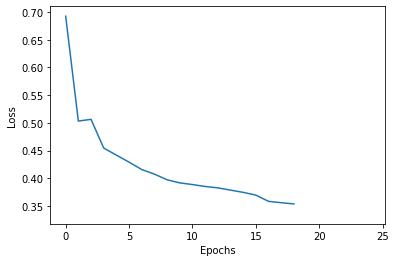

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results['with_add_lstm'])
plt.xlabel('Epochs');
plt.ylabel('Loss');
